In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



/

hub://activeloop/nih-chest-xray-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



|

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for i, layer in enumerate(model.features):
    if i % 2 == 0:
        for param in layer.parameters():
            param.requires_grad = False

num_labels = 15
in_features = model.classifier[6].in_features

in_features = 25088

classifier = nn.Sequential(
    nn.Linear(in_features, 1000),
    nn.ReLU(),
    nn.Linear(1000, num_labels),
    nn.Sigmoid()
)


model.classifier = classifier

for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = class_averaged_binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 385MB/s]


Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [01:29<00:00, 24.0MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1909
Validation phase completed. Average loss: 0.1904
Micro-averaged ROC AUC: 0.8746829702243712
Macro-averaged ROC AUC: 0.6762211053298571
ROC AUC for label 0: 0.6888565629686771
ROC AUC for label 1: 0.690155811090888
ROC AUC for label 2: 0.6439160953302359
ROC AUC for label 3: 0.5495435773798643
ROC AUC for label 4: 0.6268913098026095
ROC AUC for label 5: 0.758288709126125
ROC AUC for label 6: 0.6572252250735278
ROC AUC for label 7: 0.8035664328433403
ROC AUC for label 8: 0.6427393047766127
ROC AUC for label 9: 0.6656689902038997
ROC AUC for label 10: 0.7267296122394051
ROC AUC for label 11: 0.6505080531834396
ROC AUC for label 12: 0.6128904124280545
ROC AUC for label 13: 0.61862218585533
ROC AUC for label 14: 0.8077142976458485


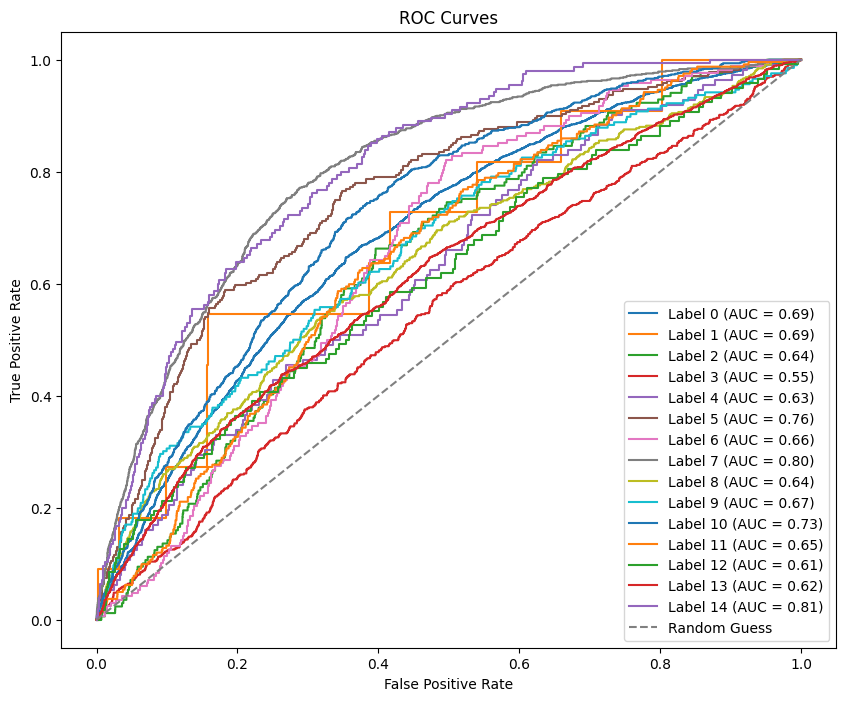

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1830
Validation phase completed. Average loss: 0.1868
Micro-averaged ROC AUC: 0.8809432410371453
Macro-averaged ROC AUC: 0.6740512891400839
ROC AUC for label 0: 0.7037932111053915
ROC AUC for label 1: 0.3615848334052245
ROC AUC for label 2: 0.679854662335461
ROC AUC for label 3: 0.5788012874484387
ROC AUC for label 4: 0.6575443292070927
ROC AUC for label 5: 0.7715104107325966
ROC AUC for label 6: 0.7125282043510474
ROC AUC for label 7: 0.8217289100876449
ROC AUC for label 8: 0.6415558535858462
ROC AUC for label 9: 0.6807398918083818
ROC AUC for label 10: 0.7518201211257683
ROC AUC for label 11: 0.678837177307613
ROC AUC for label 12: 0.6116938030529924
ROC AUC for label 13: 0.6320590524176292
ROC AUC for label 14: 0.8267175891301

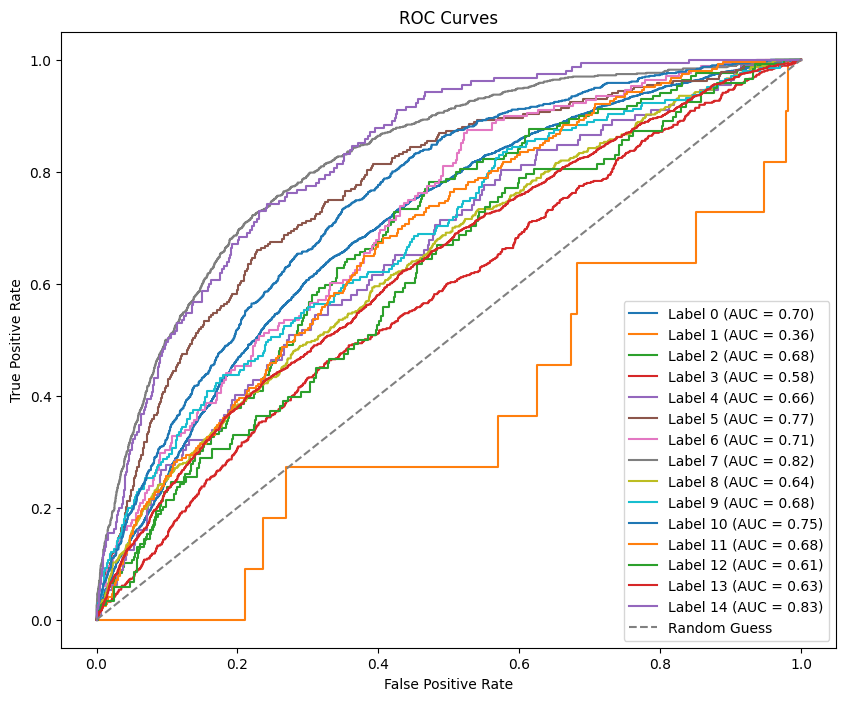

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1803
Validation phase completed. Average loss: 0.1868
Micro-averaged ROC AUC: 0.884990803541704
Macro-averaged ROC AUC: 0.7029554345977848
ROC AUC for label 0: 0.7125349688875455
ROC AUC for label 1: 0.5039294694427202
ROC AUC for label 2: 0.7015695156410977
ROC AUC for label 3: 0.5887535706888636
ROC AUC for label 4: 0.6449272331883573
ROC AUC for label 5: 0.7750250121055031
ROC AUC for label 6: 0.7916768398778653
ROC AUC for label 7: 0.8318833070136084
ROC AUC for label 8: 0.7006971199436453
ROC AUC for label 9: 0.6928976547753978
ROC AUC for label 10: 0.7539674958688973
ROC AUC for label 11: 0.6874288774677921
ROC AUC for label 12: 0.685456578471756
ROC AUC for label 13: 0.6368369402427273
ROC AUC for label 14: 0.8367469353509

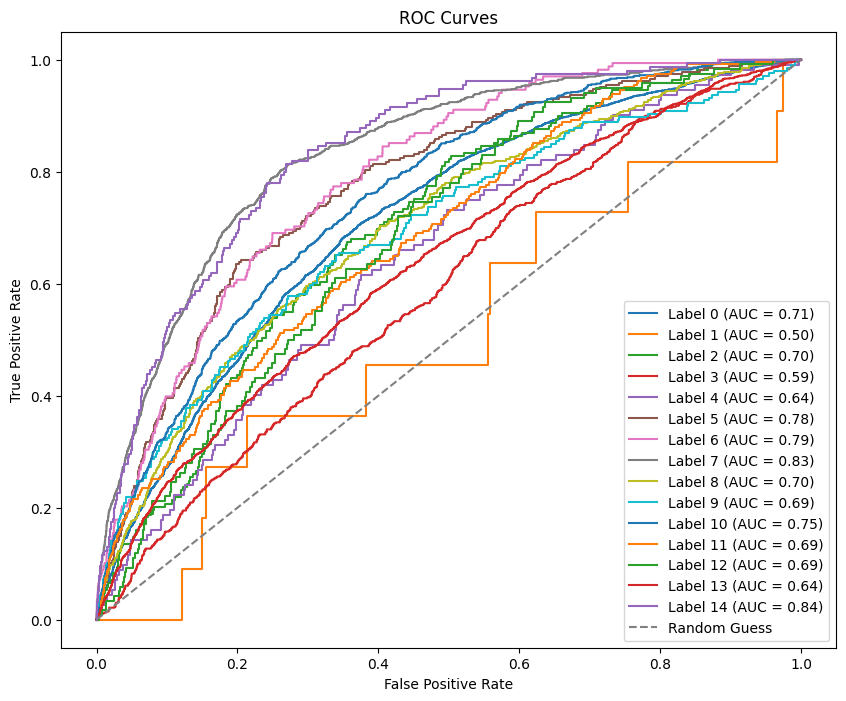

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1783
Validation phase completed. Average loss: 0.1841
Micro-averaged ROC AUC: 0.8875040785545366
Macro-averaged ROC AUC: 0.6990023826838174
ROC AUC for label 0: 0.7141290849633948
ROC AUC for label 1: 0.35456754794794376
ROC AUC for label 2: 0.6990625874094168
ROC AUC for label 3: 0.5662014501810019
ROC AUC for label 4: 0.6799107142857143
ROC AUC for label 5: 0.7733324669590974
ROC AUC for label 6: 0.8194279568262949
ROC AUC for label 7: 0.8232752058999077
ROC AUC for label 8: 0.7011632664119862
ROC AUC for label 9: 0.7051459414349069
ROC AUC for label 10: 0.7520833616194402
ROC AUC for label 11: 0.700991538998241
ROC AUC for label 12: 0.6901675451732452
ROC AUC for label 13: 0.646244556306165
ROC AUC for label 14: 0.859332515840

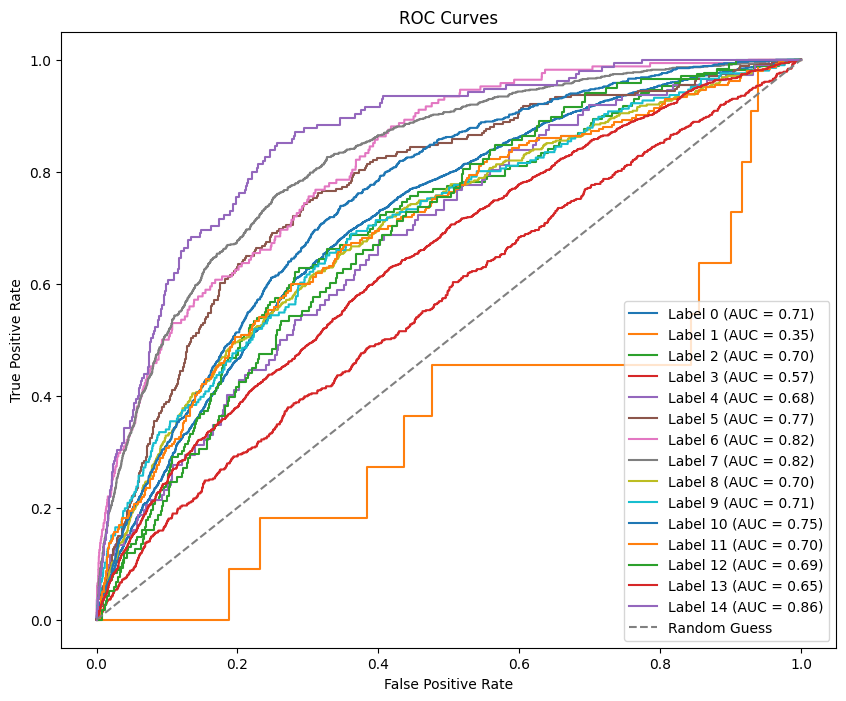

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1766
Validation phase completed. Average loss: 0.1811
Micro-averaged ROC AUC: 0.8915387144154202
Macro-averaged ROC AUC: 0.7130706512357876
ROC AUC for label 0: 0.7282999884465351
ROC AUC for label 1: 0.42445108415482213
ROC AUC for label 2: 0.7123331243063921
ROC AUC for label 3: 0.5963950603748419
ROC AUC for label 4: 0.6721823770491803
ROC AUC for label 5: 0.7751184737096957
ROC AUC for label 6: 0.839352366359085
ROC AUC for label 7: 0.8460777194958792
ROC AUC for label 8: 0.7187593811807418
ROC AUC for label 9: 0.7132985339185092
ROC AUC for label 10: 0.7661357397688819
ROC AUC for label 11: 0.7154592623893239
ROC AUC for label 12: 0.6890151259369303
ROC AUC for label 13: 0.6467311409856058
ROC AUC for label 14: 0.85245039046

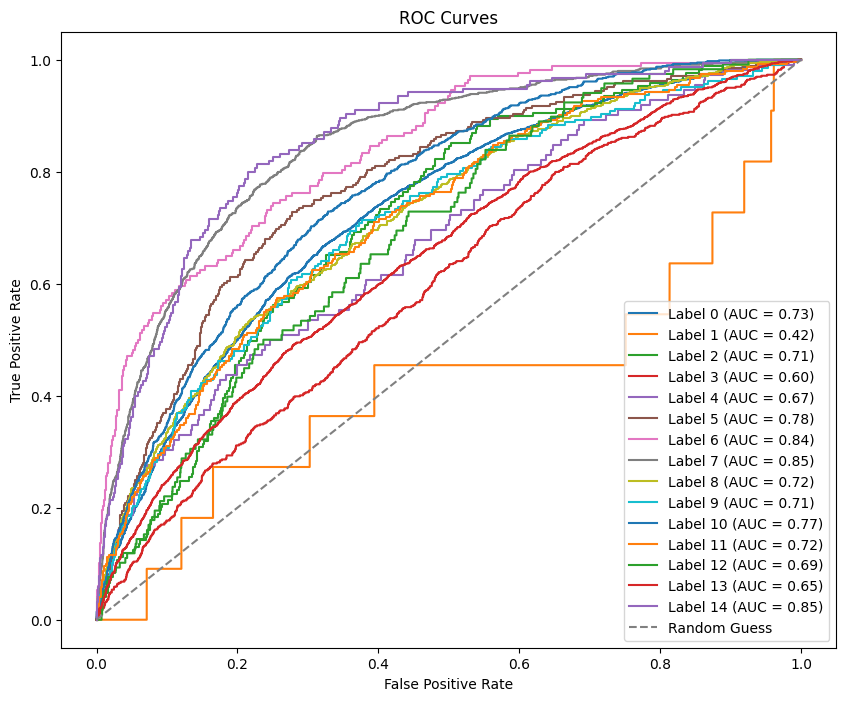

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_5.pt
------------------ Training Epoch 6 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1754
Validation phase completed. Average loss: 0.1820
Micro-averaged ROC AUC: 0.8906573965530291
Macro-averaged ROC AUC: 0.7192351674941322
ROC AUC for label 0: 0.7216581930337193
ROC AUC for label 1: 0.5139030625664117
ROC AUC for label 2: 0.7132060849858435
ROC AUC for label 3: 0.6063385018568798
ROC AUC for label 4: 0.6466272164603547
ROC AUC for label 5: 0.7821111819243477
ROC AUC for label 6: 0.8300589625289059
ROC AUC for label 7: 0.8414157101471588
ROC AUC for label 8: 0.7371543525969275
ROC AUC for label 9: 0.7159694139122559
ROC AUC for label 10: 0.7603313507767431
ROC AUC for label 11: 0.7177324810094241
ROC AUC for label 12: 0.7068237518520137
ROC AUC for label 13: 0.6417499220005105
ROC AUC for label 14: 0.85344732676

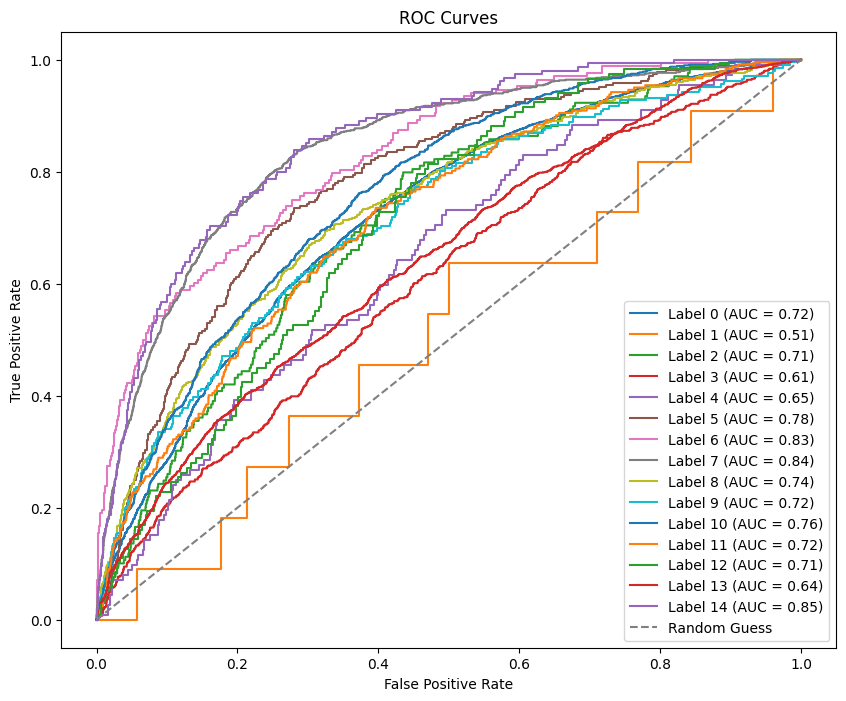

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_6.pt
------------------ Training Epoch 7 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1744
Validation phase completed. Average loss: 0.1829
Micro-averaged ROC AUC: 0.8915564048294631
Macro-averaged ROC AUC: 0.7274291953275536
ROC AUC for label 0: 0.7267007126238312
ROC AUC for label 1: 0.6492935371537385
ROC AUC for label 2: 0.7069356255148654
ROC AUC for label 3: 0.6121852251122737
ROC AUC for label 4: 0.6687207259953162
ROC AUC for label 5: 0.7736484561923208
ROC AUC for label 6: 0.8378291910823736
ROC AUC for label 7: 0.8414639645720609
ROC AUC for label 8: 0.7272746484597253
ROC AUC for label 9: 0.6979934202207514
ROC AUC for label 10: 0.7674147243761815
ROC AUC for label 11: 0.7308757775572173
ROC AUC for label 12: 0.6706772113937074
ROC AUC for label 13: 0.638743736867785
ROC AUC for label 14: 0.861680972791

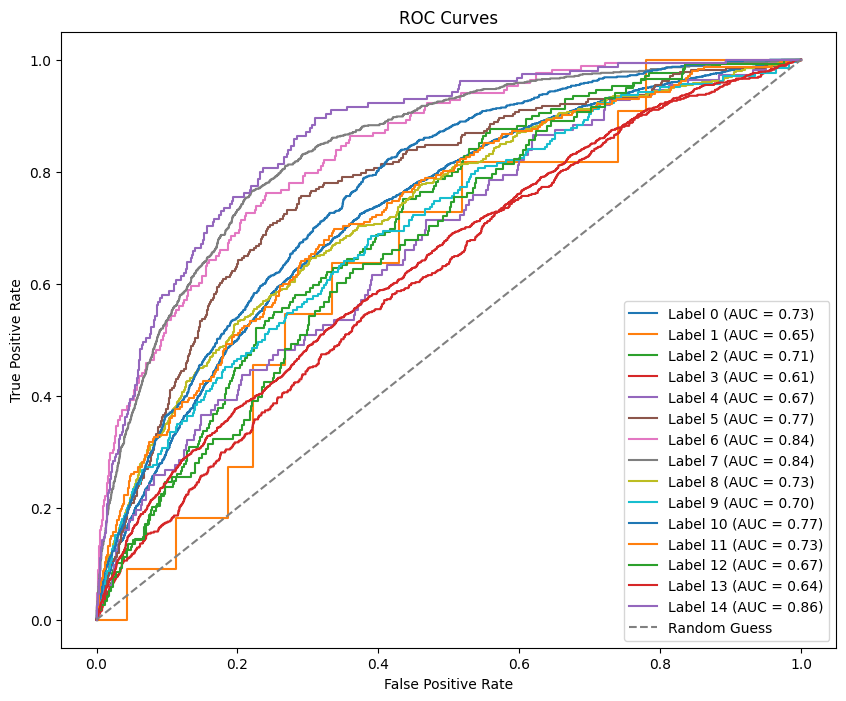

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_7.pt
------------------ Training Epoch 8 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1737
Validation phase completed. Average loss: 0.1814
Micro-averaged ROC AUC: 0.8929467528174951
Macro-averaged ROC AUC: 0.7375359777339567
ROC AUC for label 0: 0.724677627752602
ROC AUC for label 1: 0.714742611861001
ROC AUC for label 2: 0.7367299862516541
ROC AUC for label 3: 0.6087628014846196
ROC AUC for label 4: 0.6794862412177985
ROC AUC for label 5: 0.7763646284322662
ROC AUC for label 6: 0.823544950158281
ROC AUC for label 7: 0.8397163932344998
ROC AUC for label 8: 0.7387824107941152
ROC AUC for label 9: 0.7028676181520983
ROC AUC for label 10: 0.765242431236807
ROC AUC for label 11: 0.7484593803126935
ROC AUC for label 12: 0.6906352655181864
ROC AUC for label 13: 0.6491125413318408
ROC AUC for label 14: 0.863914778270888

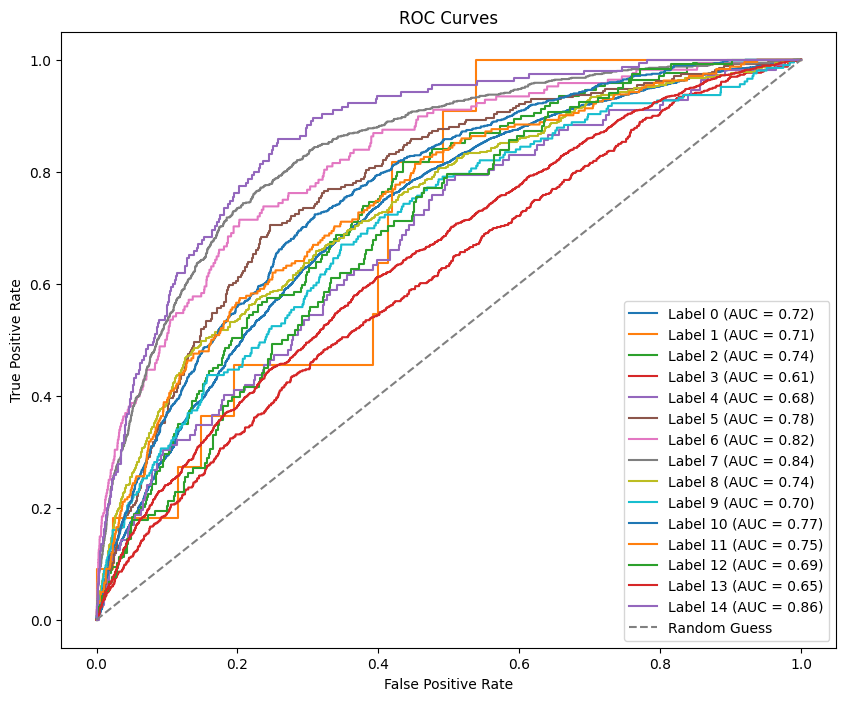

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_8.pt
------------------ Training Epoch 9 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1729
Validation phase completed. Average loss: 0.1820
Micro-averaged ROC AUC: 0.892857129151772
Macro-averaged ROC AUC: 0.7288697634015414
ROC AUC for label 0: 0.7271537875381139
ROC AUC for label 1: 0.5551651218819371
ROC AUC for label 2: 0.7270719650229801
ROC AUC for label 3: 0.6163384200706148
ROC AUC for label 4: 0.6822181331549012
ROC AUC for label 5: 0.7690002990771335
ROC AUC for label 6: 0.8433451763543701
ROC AUC for label 7: 0.840719611345075
ROC AUC for label 8: 0.7476425804004443
ROC AUC for label 9: 0.710451491945403
ROC AUC for label 10: 0.7693978134107293
ROC AUC for label 11: 0.7486745904619647
ROC AUC for label 12: 0.6888378688635289
ROC AUC for label 13: 0.6455338833332741
ROC AUC for label 14: 0.86149570816265

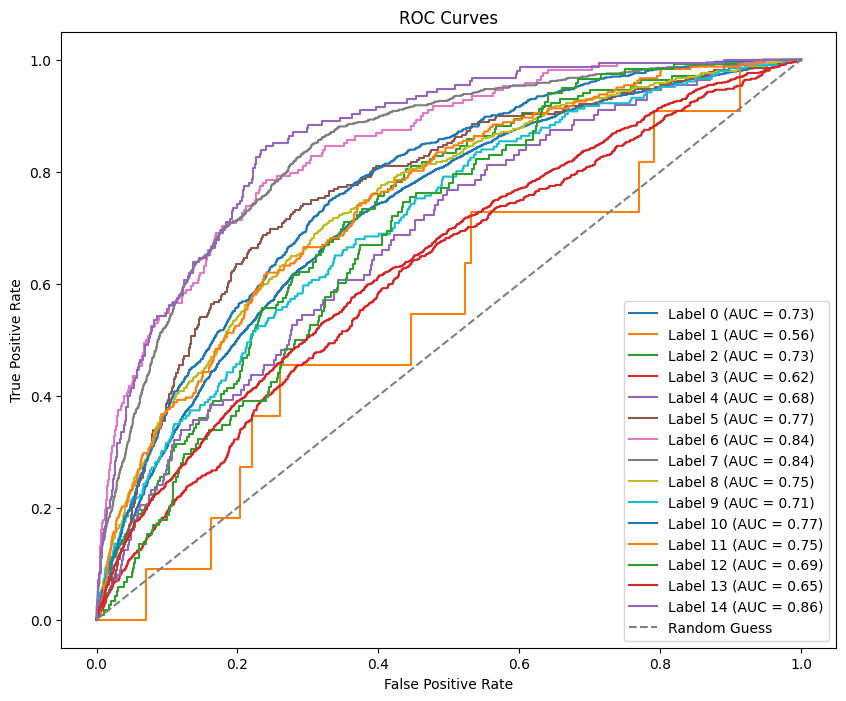

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_9.pt
------------------ Training Epoch 10 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1724
Validation phase completed. Average loss: 0.1800
Micro-averaged ROC AUC: 0.8947210275079465
Macro-averaged ROC AUC: 0.7370083517079302
ROC AUC for label 0: 0.7330222215281892
ROC AUC for label 1: 0.6566474839822831
ROC AUC for label 2: 0.7001779402871178
ROC AUC for label 3: 0.6255964042336992
ROC AUC for label 4: 0.6690835145533623
ROC AUC for label 5: 0.7686976615016521
ROC AUC for label 6: 0.8625346590781527
ROC AUC for label 7: 0.8510057026390001
ROC AUC for label 8: 0.7521222466065187
ROC AUC for label 9: 0.7316797289002204
ROC AUC for label 10: 0.7671933340095377
ROC AUC for label 11: 0.7368181326834445
ROC AUC for label 12: 0.6787451390847379
ROC AUC for label 13: 0.6563434687309808
ROC AUC for label 14: 0.8654576378

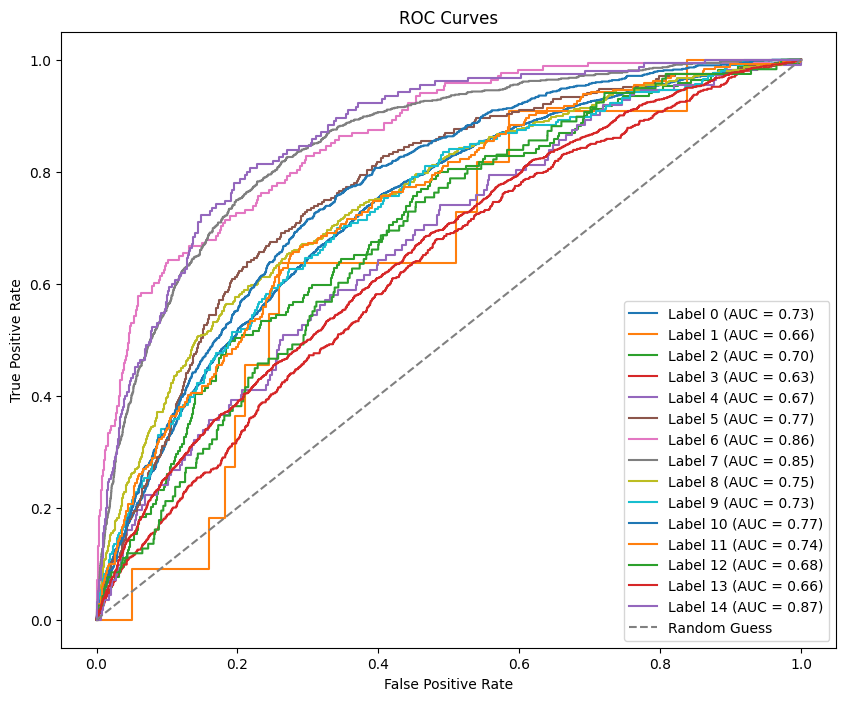

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_VGG16_checkpoint_epoch_10.pt


In [ ]:
num_epochs = 10
model_name = "SSN_VGG16"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_VGG16.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)